In [1]:
import os
import pandas as pd
import networkx as nx
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import random
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from sklearn.cluster import KMeans
from pathlib import Path

In [ ]:
# run data.py

# run functions.py


In [ ]:
# Define base directory
DATA_DIR_RAW = Path("data/raw")
DATA_DIR_PROC = Path("data/processed")

# Define file paths
USERS   = DATA_DIR_RAW / "user.json"
REVIEWS = DATA_DIR_RAW / "review.json"
REVIEWS_CLEAN = DATA_DIR_RAW / "review_clean.ndjson"
BIZ     = DATA_DIR_RAW / "business.json"

# categories of restaurants
FOOD = DATA_DIR_RAW / "Food.txt"
RESTAURANTS = DATA_DIR_RAW / "restaurants.txt"


#USERS_FILTERED = DATA_DIR_PROC / "yelp_filtered_user_ids.csv"

#special_ids = set(pd.read_csv(USERS_FILTERED)["user_id"].astype(str))

In [3]:
with open(USERS, 'r') as f:
    user_counts = Counter(json.loads(line)['user_id'] for line in f)


In [4]:
# number of unique users
num_unique_users = len(user_counts)
print(f'Number of unique users: {num_unique_users}')

Number of unique users: 1987897


In [5]:
# create graph
G = nx.Graph()
G.add_nodes_from(user_counts.keys())
with open(USERS, 'r') as f:
    for line in f:
        user = json.loads(line)
        user_id = user['user_id']
        friends = user['friends'].split(', ') if user['friends'] != 'None' else []
        for friend in friends:
            if friend in user_counts:
                G.add_edge(user_id, friend)


In [6]:
degrees = [G.degree(node) for node in G.nodes()]
sorted(degrees)
no_friends = sum(count == 0 for count in degrees)
print(f'Number of users with no friends in the network: {no_friends}')

Number of users with no friends in the network: 1081718


In [7]:
number_of_nodes_full_network = G.number_of_nodes()
number_of_edges_full_network = G.number_of_edges()
print(f'Number of nodes in the graph: {number_of_nodes_full_network}')
print(f'Number of edges in the graph: {number_of_edges_full_network}')

Number of nodes in the graph: 1987897
Number of edges in the graph: 7305874


Because we have so many single nodes, we'd rather look at the greatest component in the network, thus filtering out the nodes not connected to any and smaller subgraphs.

In [8]:
# taking the greatest component
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0])

In [9]:
number_of_nodes_greatest_component = G.number_of_nodes()
number_of_edges_greatest_component = G.number_of_edges()
print(f'Number of nodes in the graph: {number_of_nodes_greatest_component}')
print(f'Number of edges in the graph: {number_of_edges_greatest_component}')

Number of nodes in the graph: 892152
Number of edges in the graph: 7298492


In [10]:
removed_nodes = number_of_nodes_full_network-number_of_nodes_greatest_component
print(f'Number of nodes filtered away is {number_of_nodes_full_network-number_of_nodes_greatest_component}, where {removed_nodes-no_friends} had at least one friend, but were not connected to the greatest component')

Number of nodes filtered away is 1095745, where 14027 had at least one friend, but were not connected to the greatest component


In [11]:
removed_edges = number_of_edges_full_network-number_of_edges_greatest_component
print(f'Number of edges filtered away is {removed_edges}')

Number of edges filtered away is 7382


We can see that even though we filtered more than half of the edges away by only looking at the greatest component, we kept far most of the edges. From that, we know that many of the users with little to know friends were thinly connected together in small subgraphs.

In [12]:
# print degree stats
degrees_GC = [G.degree(node) for node in G.nodes()]
print(f'Average degree: {sum(degrees_GC)/G.number_of_nodes()}')
print(f'Highest degree: {max(degrees_GC)}')
print(f'Lowest degree: {min(degrees_GC)}')

Average degree: 16.361543772810016
Highest degree: 6868
Lowest degree: 1


Although we have drastically cut down on the graph by only keeping the greatest component, it is still way too large to plot, thus we take 5000 random nodes and plot them just to get some visual 

In [13]:
# select 20000 random nodes
random.seed(123)
sampled_nodes = random.sample(list(G.nodes()), 20000)
H = G.subgraph(sampled_nodes).copy()


In [14]:
number_of_nodes_full_network = H.number_of_nodes()
number_of_edges_full_network = H.number_of_edges()
print(f'Number of nodes in the graph: {number_of_nodes_full_network}')
print(f'Number of edges in the graph: {number_of_edges_full_network}')

Number of nodes in the graph: 20000
Number of edges in the graph: 3612


In [15]:
# taking the greatest component
Hcc = sorted(nx.connected_components(H), key=len, reverse=True)
H = H.subgraph(Hcc[0])

In [16]:
number_of_nodes_full_network = H.number_of_nodes()
number_of_edges_full_network = H.number_of_edges()
print(f'Number of nodes in the graph: {number_of_nodes_full_network}')
print(f'Number of edges in the graph: {number_of_edges_full_network}')

Number of nodes in the graph: 1242
Number of edges in the graph: 1786


In [17]:
degrees_HC = [H.degree(node) for node in H.nodes()]
print(f'Average degree: {sum(degrees_HC)/H.number_of_nodes()}')
print(f'Highest degree: {max(degrees_HC)}')
print(f'Lowest degree: {min(degrees_HC)}')

Average degree: 2.8760064412238324
Highest degree: 59
Lowest degree: 1


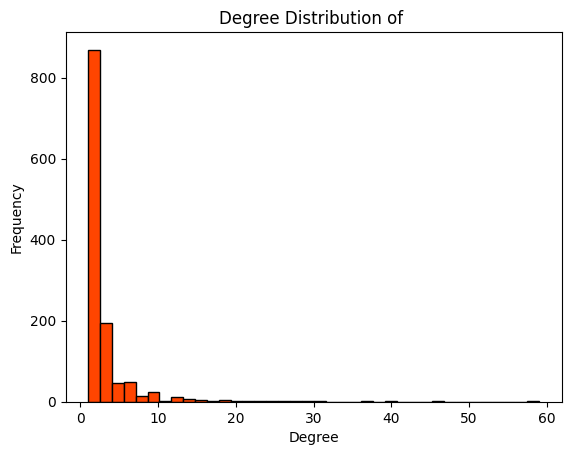

In [18]:
# plot the degree distribution in a histogram
plt.hist(degrees_HC, bins=38, color='orangered', edgecolor='black')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Distribution of ')
plt.show()

Highly skewed degree distribution, with many nodes not having many friends.

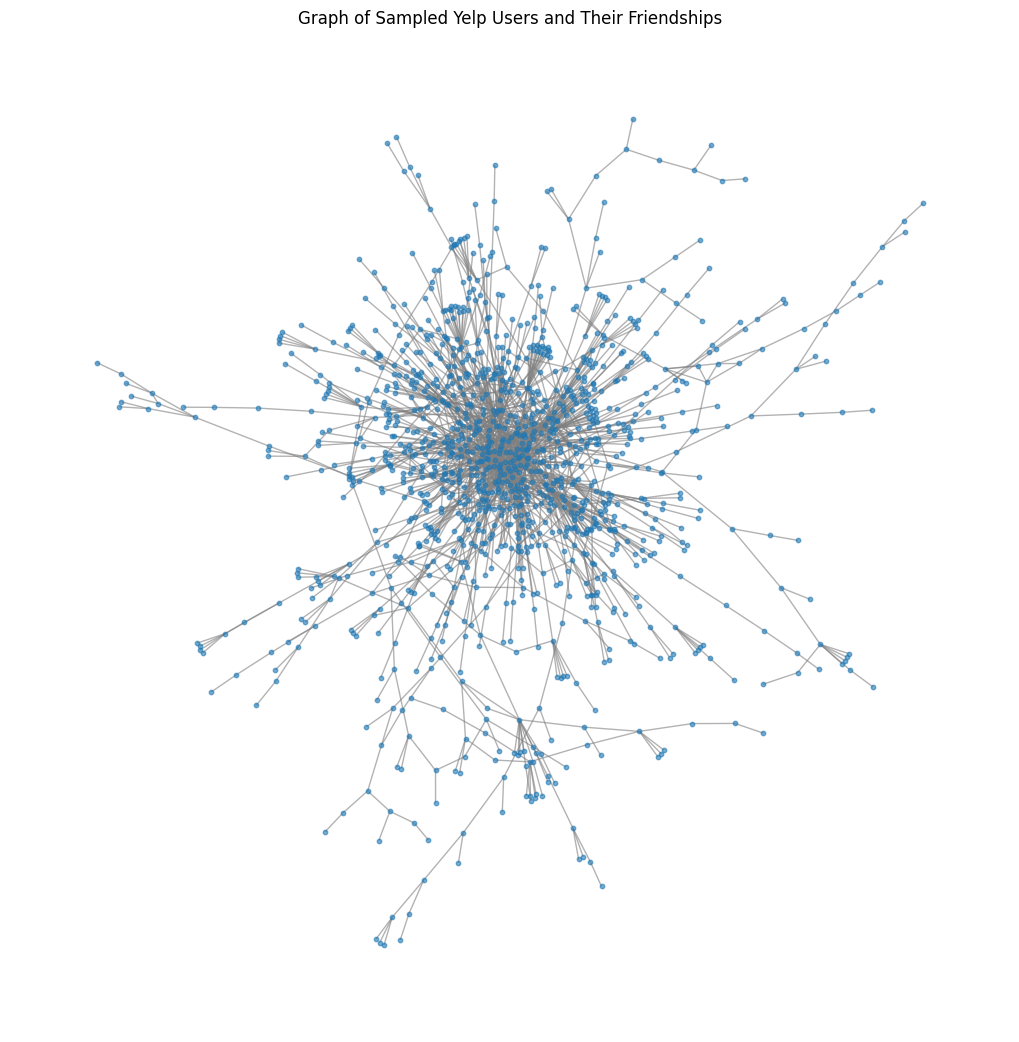

In [19]:
plt.figure(figsize=(10, 10))
nx.draw(H, node_size=10, alpha=0.6, edge_color="gray", with_labels=False)
plt.title("Graph of Sampled Yelp Users and Their Friendships")
plt.show()

In [20]:
graph_dict = nx.to_dict_of_lists(H)

In [23]:
sorted_betweenness = sorted(betweenness_centrality_normalized(graph_dict).items(), key=lambda x: x[1], reverse=True)
print("Top 10 users by betweenness centrality:")
for user, centrality in sorted_betweenness[:10]:
    print(f'User ID: {user}, Betweenness Centrality: {centrality}')

Top 10 users by betweenness centrality:
User ID: oazuTtSyKV6zrhbsgbdbUQ, Betweenness Centrality: 0.31383506404886374
User ID: xSmJ4WZCxnLePHIM95ZhcQ, Betweenness Centrality: 0.14012528211186367
User ID: 6s5whJLSvZFIF0Am4RyjUg, Betweenness Centrality: 0.11387164178135627
User ID: HPqD_nATHVuVjTyt0Rxatg, Betweenness Centrality: 0.10749285352056549
User ID: _cpU0VVdQcfN5AnuL6M56A, Betweenness Centrality: 0.10653557214556408
User ID: pCpZ6KF0vCOF3fyj9W8iMg, Betweenness Centrality: 0.09116290249812538
User ID: NE0Mx9NLNUi9eVUpM5v1Gw, Betweenness Centrality: 0.08370371671433481
User ID: j21ko3sZDUEKpboYcD0WWw, Betweenness Centrality: 0.0829689505366419
User ID: pufGgg3EuY_As7cu__pM1w, Betweenness Centrality: 0.07362533915740355
User ID: poauwxPbF2j416nvHMnQhQ, Betweenness Centrality: 0.07166761976553877


In [26]:
# Comparing to the built-in function
betweenness_centrality_built_in = nx.betweenness_centrality(H)
sorted_betweenness_built_in = sorted(betweenness_centrality_built_in.items(), key=lambda x: x[1], reverse=True)
print("Top 10 users by betweenness centrality (built-in):")
for user, centrality in sorted_betweenness_built_in[:10]:
    print(f'User ID: {user}, Betweenness Centrality: {centrality}')

Top 10 users by betweenness centrality (built-in):
User ID: oazuTtSyKV6zrhbsgbdbUQ, Betweenness Centrality: 0.31383506404886374
User ID: xSmJ4WZCxnLePHIM95ZhcQ, Betweenness Centrality: 0.14012528211186367
User ID: 6s5whJLSvZFIF0Am4RyjUg, Betweenness Centrality: 0.11387164178135627
User ID: HPqD_nATHVuVjTyt0Rxatg, Betweenness Centrality: 0.10749285352056549
User ID: _cpU0VVdQcfN5AnuL6M56A, Betweenness Centrality: 0.10653557214556408
User ID: pCpZ6KF0vCOF3fyj9W8iMg, Betweenness Centrality: 0.09116290249812538
User ID: NE0Mx9NLNUi9eVUpM5v1Gw, Betweenness Centrality: 0.08370371671433481
User ID: j21ko3sZDUEKpboYcD0WWw, Betweenness Centrality: 0.0829689505366419
User ID: pufGgg3EuY_As7cu__pM1w, Betweenness Centrality: 0.07362533915740355
User ID: poauwxPbF2j416nvHMnQhQ, Betweenness Centrality: 0.07166761976553877


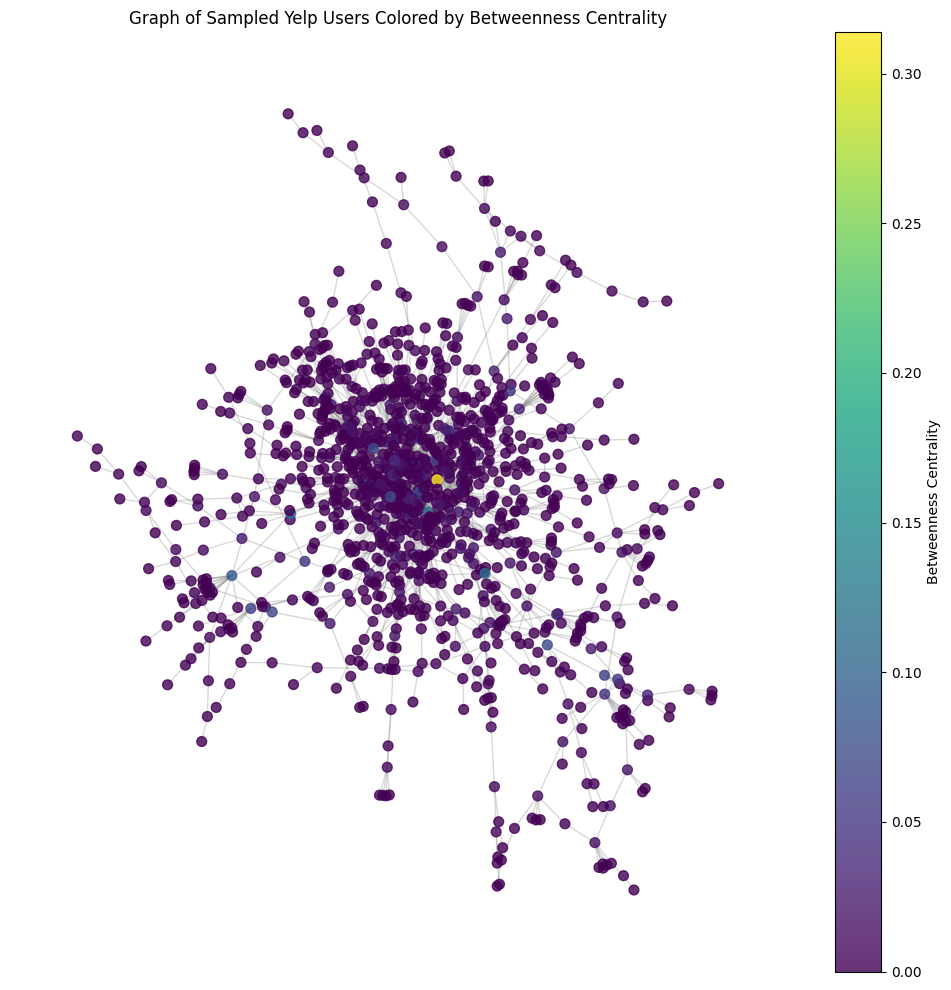

In [27]:
# Change to the manual calculation
node_colors = [betweenness_centrality_built_in[n] for n in H.nodes()]

pos = nx.spring_layout(H, seed=42)

fig, ax = plt.subplots(figsize=(10, 10))

nodes = nx.draw_networkx_nodes(
    H, pos, ax=ax,
    node_size=50,
    node_color=node_colors,
    cmap=plt.cm.viridis,
    alpha=0.8
)
nx.draw_networkx_edges(H, pos, ax=ax, edge_color="gray", alpha=0.3)

ax.set_title("Graph of Sampled Yelp Users Colored by Betweenness Centrality")
ax.set_axis_off()

cbar = fig.colorbar(nodes, ax=ax)
cbar.set_label("Betweenness Centrality")

plt.tight_layout()
plt.show()

In [29]:
mods = {}
for k in range(2, 30):
    labels = spectral_clustering(graph_dict, k)
    communities = {}
    for node, lbl in labels.items():
        communities.setdefault(lbl, []).append(node)
    mods[k] = nx.algorithms.community.quality.modularity(H, communities.values())

print(mods)
print("Optimal number of clusters (k) based on highest modularity:", max(mods, key=mods.get))

{2: 0.07212875055332686, 3: 0.11416639183195407, 4: 0.14914699874223922, 5: 0.15835307336268523, 6: 0.1704938184134659, 7: 0.18950851402409435, 8: 0.2013984593372115, 9: 0.1906275511035815, 10: 0.23421168626457603, 11: 0.29686631997782925, 12: 0.2798001815790099, 13: 0.2955435081114905, 14: 0.29779616000521647, 15: 0.285525782840031, 16: 0.29195142886880526, 17: 0.2956584057413076, 18: 0.3059103152678101, 19: 0.29073787163818615, 20: 0.2883494743864497, 21: 0.2511878502575086, 22: 0.29476712617358597, 23: 0.32089904808959563, 24: 0.3274743902117878, 25: 0.31013488009891527, 26: 0.35617622568966784, 27: 0.3373104424232771, 28: 0.3678979784287145, 29: 0.33769510652091855}
Optimal number of clusters (k) based on highest modularity: 28


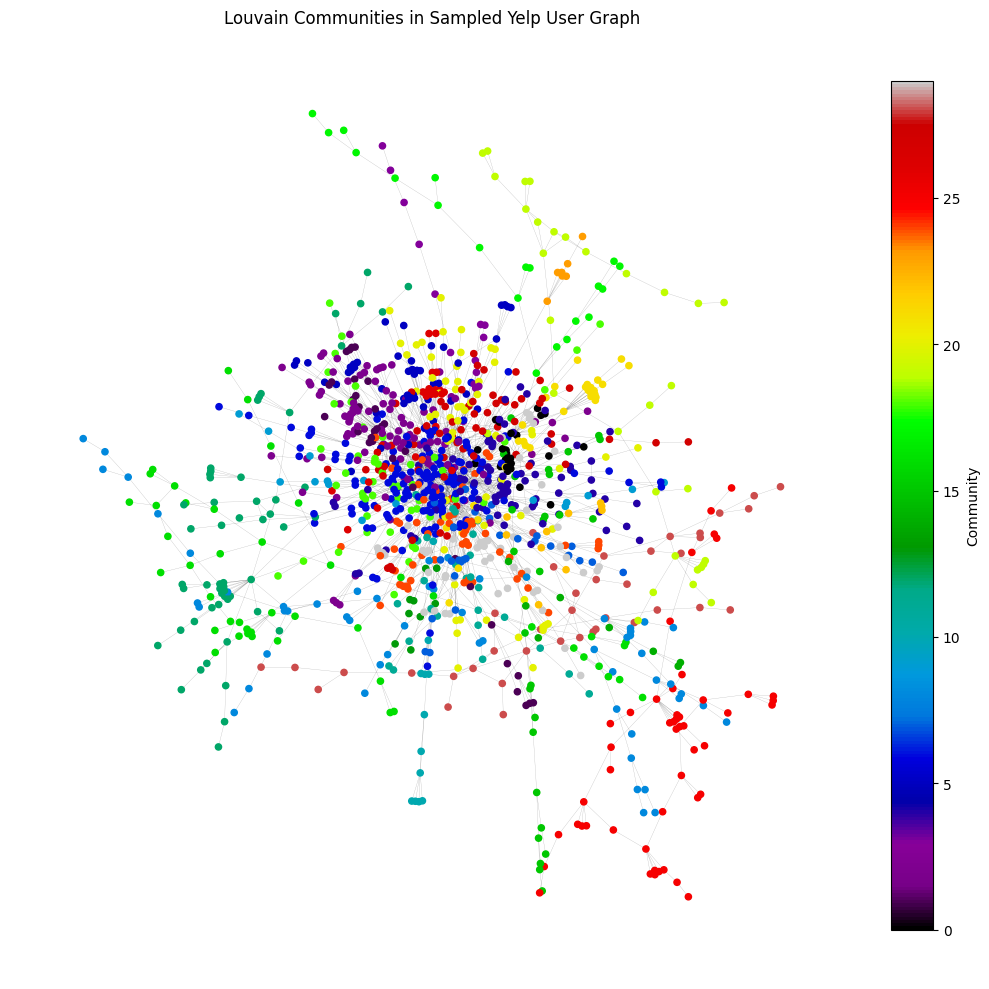

In [30]:
import community.community_louvain as community_louvain  # correct import

# Louvain partition
partition = community_louvain.best_partition(H)

# Map community labels
com_ids = {c: i for i, c in enumerate(sorted(set(partition.values())))}
node_colors = [com_ids[partition[n]] for n in H.nodes()]
num_comms = len(com_ids)

pos = nx.spring_layout(H, seed=42)

fig, ax = plt.subplots(figsize=(10, 10))
nodes = nx.draw_networkx_nodes(
    H, pos, ax=ax,
    nodelist=list(H.nodes()),
    node_size=20,
    node_color=node_colors,
    cmap=plt.cm.tab20 if num_comms <= 20 else plt.cm.viridis
)
nx.draw_networkx_edges(H, pos, ax=ax, alpha=0.3, width=0.2)
# Use a qualitative colormap for better distinction between communities
nodes.set_cmap(plt.cm.tab20b if num_comms <= 20 else plt.cm.nipy_spectral)
ax.set_title("Louvain Communities in Sampled Yelp User Graph")
ax.set_axis_off()

cbar = fig.colorbar(nodes, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Community")
if num_comms <= 20:
    cbar.set_ticks(range(num_comms))
    cbar.set_ticklabels(range(num_comms))

plt.tight_layout()
plt.show()


In [35]:
import pandas as pd
sizes = pd.Series(list(partition.values())).value_counts()
print(sizes)


6     153
2     101
4      78
27     63
20     61
29     58
24     58
8      56
12     54
5      52
18     49
25     49
16     46
28     39
1      34
19     32
21     30
15     27
7      27
11     26
0      25
26     25
17     20
9      16
3      16
10     12
22     11
13      9
14      8
23      7
Name: count, dtype: int64


In [36]:
# user_ids in community 6
users_in_community_6 = [node for node, comm in partition.items() if comm == 6]
print(f'User IDs in community 6: {users_in_community_6}')

User IDs in community 6: ['PLCijWEcAk74aiYxHb_tYA', 'XHqFhBKoo5e74ia8YoGcCg', 'IpvssHjj-IH4M5Z7xD1Ucg', 'y_P696ItONtTXS3MtqWv4Q', 'SgqocLuiOoIP5jB46KKQIA', '1wE7oHKgNOLPM0QWS3jm9w', 'lFiECT9rClw-61eeLrYHSA', 'exBaJu2r2mtiCJjbLBAhig', 'xqZvHmNaWIFqqwxUQqh5Gw', 'BtnH3TyOCL-X2YVXd3PWQA', 'hmwKaQN_f0dnymp7XH2R2w', 'xJJOw432loL-0PmmZzRJWQ', 'i9rJtYWADcATncRgWsAy7A', 'KMNrOXkfx7CLAaxA6y0dWw', 'ABYJ_vl-sFVUC8Yj4uv1QQ', 'beuKGQICj0KByugwnHcgpw', 'i7K7MR8Nz1jiFbRS1D4D6A', 'nLS21IIrKYFjWZdhfQi8Jg', 'HRDWzhi0YRqZy5wd_aVFEg', 'CVXX2MOvMbbmhHLqvDH8AA', 'ox1K3lo9drQsO9FnByNr8g', 'h2nJxjwZlC8aXNEh_puMpw', '-dccg5dCgQRh8ObtNvrj3g', 'NrCzwcvmkKR-b4gNehV8Sg', 'Wd4FRRD30avk-Mj6C_O2ow', 'jDLu-TN_g9f3Djh_KiNS4Q', 'nh6ArLduHi_53eMPMW0fgw', 'jOfwlMn8hHEk68XFkxjsvw', '2Gy7OX3zFVfNeeHLhmpzJw', 'uEtmPBY0VAe_oC-RZb6ZKg', 'v92dlv--Ee88fhM6P-Ftvw', '4xa3C7Jblxe0b4uC_aZMQQ', 'OrdJuv0n81GgfAL_BAPNsA', 'oJBUXpkWLEQMwRWi4XQnxA', 'm0xVOMZZWWgc-E7iqq9a5A', 'd524yvZOkUEg2CwylUYvRQ', 'QXimk2cC9YnC7Ee5XIKozg', 'bcE79CNoNY0

In [37]:
import networkx as nx
from networkx.algorithms.community import modularity

comms = {}
for n,c in partition.items():
    comms.setdefault(c, []).append(n)

modularity_score = modularity(H, comms.values())
print(modularity_score)

0.7351835352480223


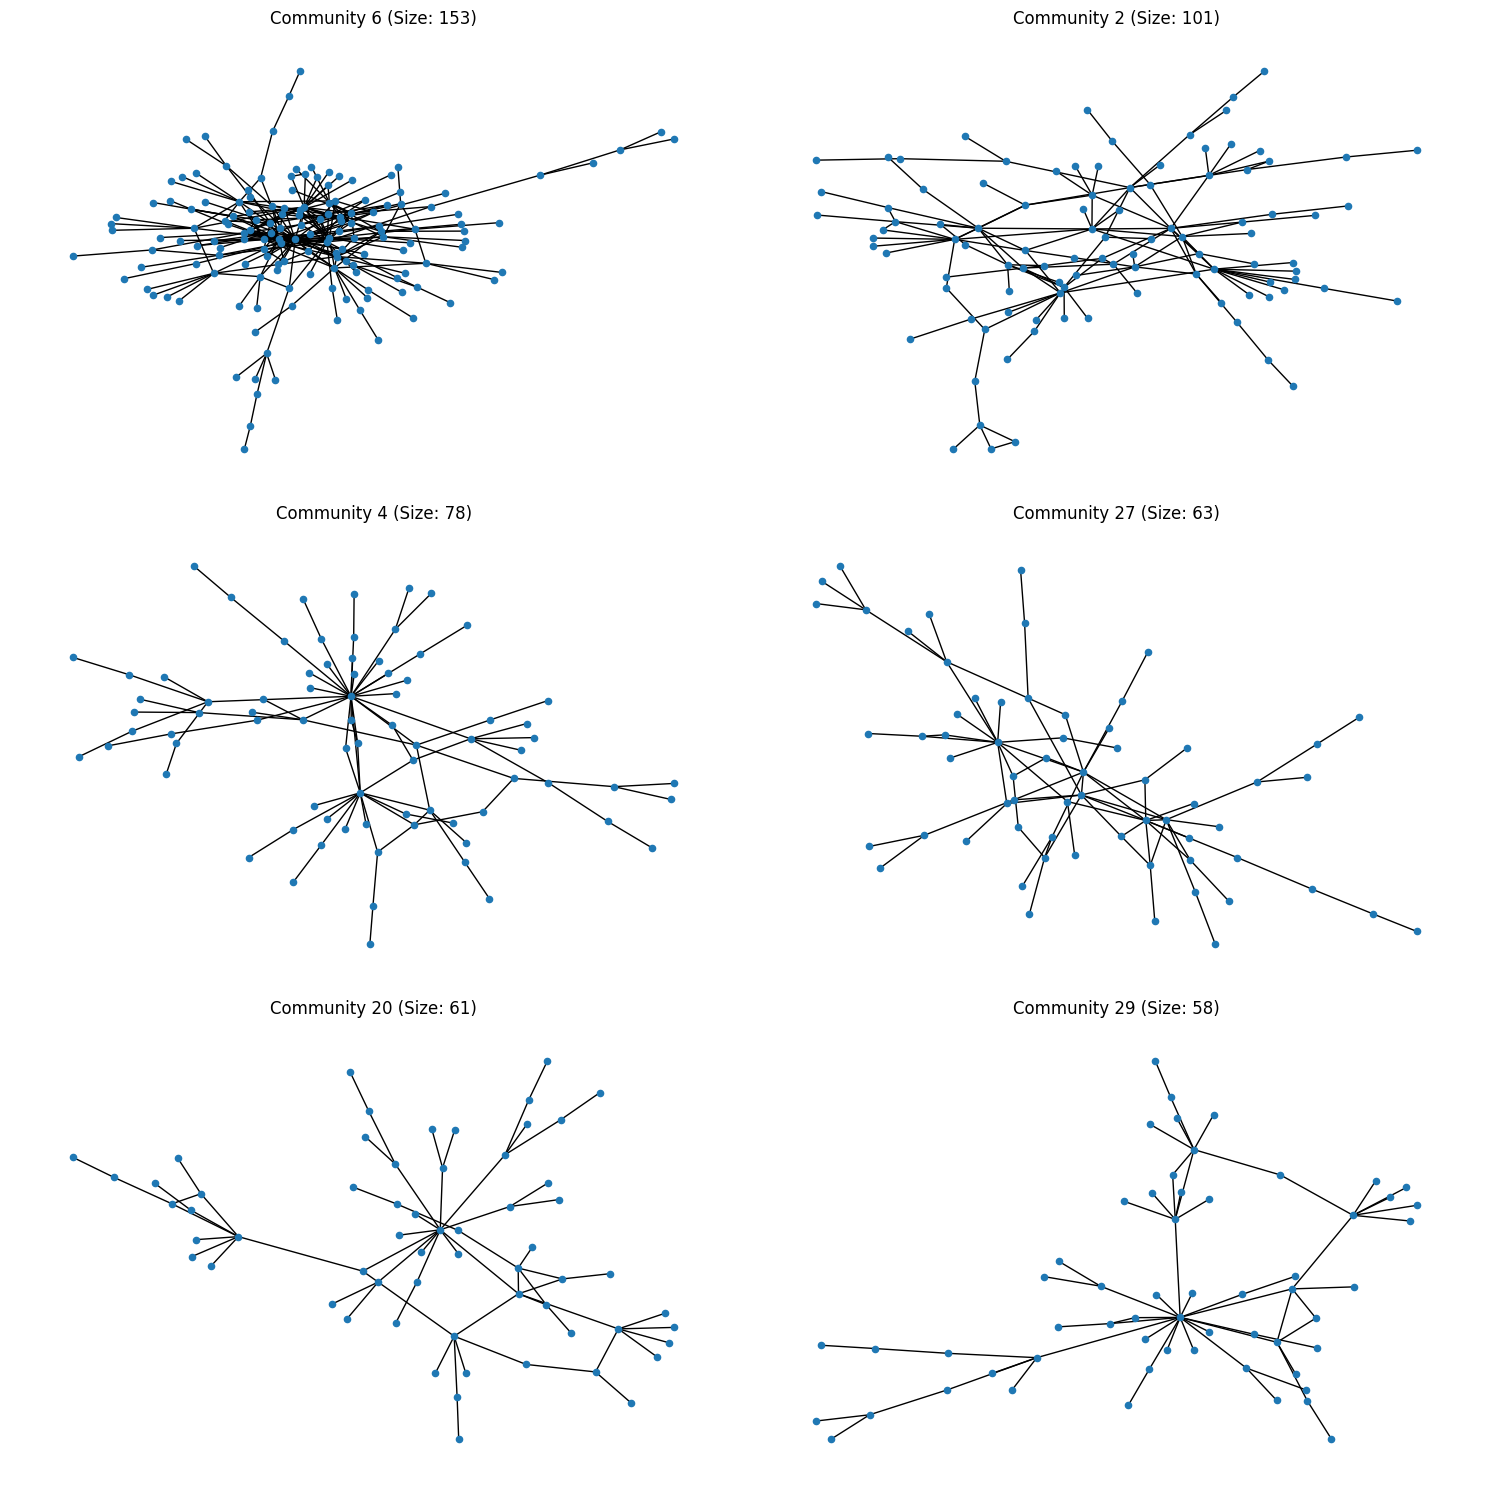

In [38]:
top_6_communities = sizes.index[:6]

plt.figure(figsize=(15, 15))
for i, community in enumerate(top_6_communities, 1):
    nodes = [n for n, c in partition.items() if c == community]
    sub = H.subgraph(nodes)
    plt.subplot(3, 2, i)
    nx.draw(sub, with_labels=False, node_size=20)
    plt.title(f'Community {community} (Size: {sizes[community]})')

plt.tight_layout()
plt.show()
